# Building an AWS Solution Architect Agent with Generative AI

This notebook walks through  building an AI-powered Solution Architect Agent dubbed "Agent AWS" using HuggingFace Transformers and AWS Sagemaker.

The three tools for Agent AWS are:

1. **AWS Well-Architected Framework Query Tool**: This tool will allow your agent to interact directly with the AWS Well-Architected Framework, extracting valuable data to inform architectural decisions.
2. **Code Generation Tool:** This tool will generate code from AWS CloudFormation scripts to Java code.
3. **Diagram Creation Tool:** This tool will create AWS diagrams.


**You need to have your own HuggingFace API key to use these tools.** 
Learn how to get your own free key here https://huggingface.co/docs/hub/security-tokens




## Agent AWS

**Agent AWS** is an automated, AI-powered agent that uses HuggingFace Transformers paired with numerous different foundation models. 

An “agent” here is a large language model (LLM) equipped with a prompt and access to a specific set of tools. Tools are self-contained functions that perform a singular task that the agent can use when given an instruction.

Agent AWS contains a set of tools that allows it to query AWS documentation, generating code, and creating architectural diagrams.

In [ ]:
# Prereqs
!pip install -U langchain transformers sentence_transformers torch faiss-cpu diagrams graphviz
!apt-get update && apt-get install graphviz -y
print("Done, please continue!!!")

In [1]:
import json
import os
import subprocess
from typing import Dict

import requests
from langchain import PromptTemplate, SagemakerEndpoint
from langchain.chains.question_answering import load_qa_chain
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.llms.sagemaker_endpoint import LLMContentHandler
from langchain.prompts.prompt import PromptTemplate
from langchain.vectorstores import FAISS
from PIL import Image
from transformers import Tool
from transformers.tools import HfAgent

os.environ["TOKENIZERS_PARALLELISM"] = "false"
# Learn how to get your own free key here https://huggingface.co/docs/hub/security-tokens
HUGGING_FACE_KEY = os.environ["HUGGING_FACE_KEY"] # REPLACE WITH YOUR KEY

## Agent Prompt

The language model powering the agent is conditioned on a long prompt that the user provides. Using that prompt the model is able to generate words to complete the user’s request. 

The prompt is structured broadly into two parts.

1. **Role:** How the agent should behave, explanation of the concept of tools.
2. **Instructions:** Provides examples of tasks and their solutions


In [2]:
sa_prompt = """
You are an expert AWS Certified Solutions Architect. Your role is to help customers understand best practices on building on AWS. You will generate Python commands using available tools to help will customers solve their problem effectively.
To assist you, you have access to three tools. Each tool has a description that explains its functionality, the inputs it takes, and the outputs it provides.
First, you should explain which tool you'll use to perform the task and why. Then, you'll generate Python code. Python instructions should be simple assignment operations. You can print intermediate results if it's beneficial.

Tools:
<<all_tools>>

Task: "Help customers understand best practices on building on AWS by using relevant context from the AWS Well-Architected Framework."

I will use the AWS Well-Architected Framework Query Tool because it provides direct access to AWS Well-Architected Framework to extract information.

Answer:
```py
response = well_architected_tool(query="How can I design secure VPCs?")
print(f"{response}.")
```

Task: "Write a function in Python to upload a file to Amazon S3"

I will use the Code Generation Tool because it can generate code based on the provided requirements.

Answer:
```py

python_code = code_generation_tool(prompt="Write a function in Python to upload a file to Amazon S3")
print(f"{python_code}")
```

Task: "Create a diagram for the following architecture: three EC2 instances connected to an S3 bucket and a RDS database."

I will use the Diagram Creation Tool because it can create insightful diagrams to represent the given AWS architecture.

Answer:

```py
architecture_diagram = diagram_creation_tool(query="Three EC2 instances connected to an S3 bucket and a RDS database.")
```


Task: "<<prompt>>"

I will use the following
"""

## Tools

Now that we have defined our agent prompt, the next step is to create the tools for the agent to use. Creating a tool for our agent begins by establishing a class that inherits from the superclass Tool and the following attributes.

* **name:**' This is the name of the tool.
* **description:**' This will be used to populate the prompt of the agent.
* **inputs and outputs:**' These aid the interpreter in making informed decisions regarding data types. They both consist of a list of possible values which could be text, image, or audio.
  * **text:**' This type would be used when the input or output is a string of words, like a question to the tool or an answer from it.
  * **image:**' This would be chosen if the input or output is a picture or diagram. For example, if the user wanted to analyze an architectural diagram or if the tool needed to output a diagram to illustrate its answer.
  * **audio:**' This type would be selected when the input or output is a sound or speech, which might be useful for voice-based interaction scenarios.
* **A call method:**' This contains the inference code.



### AWS Well-Architected Framework Query Tool
This tool will allow your agent to interact directly with the AWS Well-Architected Framework, extracting valuable data to inform architectural decisions.

This tool leverages a vector database to deliver relevant answers to user queries.

**Resources:**
1. https://www.buildon.aws/posts/well-arch-chatbot

In [3]:
QUERY_MODEL = "tiiuae/falcon-7b-instruct"
# Try other models from https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard

class AWSWellArchTool(Tool):
    name = "well_architected_tool"
    description = "Use this tool for any AWS related question to help customers understand best practices on building on AWS. It will use the relevant context from the AWS Well-Architected Framework to answer the customer's query. The input is the customer's question. The tool returns an answer for the customer using the relevant context."
    inputs = ["text"]
    outputs = ["text"]

    def call_endpoint(self, payload):
        headers = {"Authorization": f"Bearer {HUGGING_FACE_KEY}"}

        API_URL = (
            f"https://api-inference.huggingface.co/models/{QUERY_MODEL}"
        )
        try:
            response = requests.post(API_URL, headers=headers, json=payload)
        except Exception as e:
            # just try again
            time.sleep(5)
            response = requests.post(API_URL, headers=headers, json=payload)
        return response.json()

    def __call__(self, query):
        # Find docs
        embeddings = HuggingFaceEmbeddings()
        vectorstore = FAISS.load_local("local_index", embeddings)
        docs = vectorstore.similarity_search(query)
        context = ""

        doc_sources_string = ""
        for doc in docs:
            doc_sources_string += doc.metadata["source"] + "\n"
            context += doc.page_content

        prompt = f"""Use the following pieces of context to answer the question at the end.

        {context}

        Question: {query}
        Answer:"""

        output = self.call_endpoint(
            {
                "inputs": prompt,
                "parameters": {
                    "do_sample": False,
                    "max_new_tokens": 500,
                    "return_full_text": False,
                    "temperature": 0.01,
                },
            }
        )
        generated_text = output[0]["generated_text"]
        print(generated_text)

        resp_json = {"ans": str(generated_text), "docs": doc_sources_string}
        return resp_json

In [4]:
#### Using the Tool
query = "How can I design secure VPCs?"
well_arch_tool = AWSWellArchTool()
well_arch_tool(query)

 To design secure VPCs, you should apply multiple controls with a defense in depth approach for both inbound and outbound traffic, including the use of security groups (stateful inspection firewall), Network ACLs, subnets, and route tables. Within a VPC, you can create subnets in an Availability Zone. Each subnet can have an associated route table that defines routing rules for managing the paths that traffic takes within the subnet. You can define an internet routable subnet by having a route that goes to an internet or NAT gateway attached to the VPC, or through another VPC. You should also consider using a VPN gateway to securely connect to your VPC. Additionally, you should use a combination of security groups and network ACLs to restrict access to your VPC.


{'ans': ' To design secure VPCs, you should apply multiple controls with a defense in depth approach for both inbound and outbound traffic, including the use of security groups (stateful inspection firewall), Network ACLs, subnets, and route tables. Within a VPC, you can create subnets in an Availability Zone. Each subnet can have an associated route table that defines routing rules for managing the paths that traffic takes within the subnet. You can define an internet routable subnet by having a route that goes to an internet or NAT gateway attached to the VPC, or through another VPC. You should also consider using a VPN gateway to securely connect to your VPC. Additionally, you should use a combination of security groups and network ACLs to restrict access to your VPC.',
 'docs': 'https://docs.aws.amazon.com/wellarchitected/latest/security-pillar/sec_network_protection_layered.html\nhttps://docs.aws.amazon.com/wellarchitected/latest/framework/sec_network_protection_layered.html\nhttp

### Code Generation Tool
This tool will generate code from AWS CloudFormation scripts to Python code.

This notebook is using the Starcoder model hosted on HuggingFace.

**Resources:**
1. https://huggingface.co/bigcode/starcoder

In [5]:
CODE_MODEL = "bigcode/starcoder"
# Try other models from https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard


class CodeGenerationTool(Tool):
    name = "code_generation_tool"
    description = "Use this tool only when you need to generate code based on a customers's request. The input is the customer's question. The tool returns code that the customer can use."

    inputs = ["text"]
    outputs = ["text"]

    def call_endpoint(self, payload):
        API_URL = f"https://api-inference.huggingface.co/models/{CODE_MODEL}"
        headers = {"Authorization": f"Bearer {HUGGING_FACE_KEY}"}
        response = requests.post(API_URL,headers=headers, json=payload)
        return response.json()

    def __call__(self, prompt):
        output = self.call_endpoint(
            {
                "inputs": prompt,
                "parameters": {
                    "do_sample": False,
                    "max_new_tokens": 500,
                    "return_full_text": False,
                    "temperature": 0.01,
                },
            }
        )
        generated_text = output[0]["generated_text"]
        # Clean up code
        lines = generated_text.split("\n")
        updated_lines = []

        for line in lines:
            if line == ".":
                line = line.replace(".", "")
            if "endoftext" in line:
                line = ""

            updated_lines.append(line)

        # Join the updated lines to create the updated code
        updated_code = "\n".join(updated_lines)

        return updated_code

In [6]:
#### Using the Tool
query = "Write a function in Python to upload a file to Amazon S3"
code_gen_tool = CodeGenerationTool()
code_gen_tool(query)

'\n\nimport boto3\n\ndef upload_file_to_s3(file_name, bucket, object_name=None):\n    """Upload a file to an S3 bucket\n\n    :param file_name: File to upload\n    :param bucket: Bucket to upload to\n    :param object_name: S3 object name. If not specified then file_name is used\n    :return: True if file was uploaded, else False\n    """\n\n    # If S3 object_name was not specified, use file_name\n    if object_name is None:\n        object_name = file_name\n\n    # Upload the file\n    s3_client = boto3.client(\'s3\')\n    try:\n        response = s3_client.upload_file(file_name, bucket, object_name)\n    except ClientError as e:\n        logging.error(e)\n        return False\n    return True\n'

### Diagram Creation Tool
This tool will create AWS diagrams using the Diagrams library.

**Resources:**
1. https://github.com/mingrammer/diagrams

In [7]:
DIAGRAM_MODEL = "bigcode/starcoder"
# Try other models from https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard


class DiagramCreationTool(Tool):
    name = "diagram_creation_tool"
    description = ("This is a tool that generates diagrams based on a customers's request.")
    inputs = ["text"]
    outputs = ["image"]

    def save_and_run_python_code(self,code: str, file_name: str = "test_diag.py"):
        # Save the code to a file
        with open(file_name, "w") as file:
            file.write(code)

        # Run the code using a subprocess
        try:
            result = subprocess.run(
                ["python", file_name], capture_output=True, text=True, check=True
            )
        except subprocess.CalledProcessError as e:
            print("Error occurred while running the code:")
            print(e.stdout)
            print(e.stderr)
    
    def process_code(self, code):
        # Split the code into lines
        lines = code.split("\n")

        # Initialize variables to store the updated code and diagram filename
        updated_lines = []
        diagram_filename = None
        inside_diagram_block = False

        for line in lines:
            
            if line == ".":
                line = line.replace(".","")
            if "endoftext" in line:
                line = ""
            if "# In[" in line:
                line = ""

            # Check if the line contains "with Diagram("
            if "with Diagram(" in line:
                # Extract the diagram name between "with Diagram('NAME',"
                diagram_name = (
                    line.split("with Diagram(")[1].split(",")[0].strip("'").strip('"')
                )

                # Convert the diagram name to lowercase, replace spaces with underscores, and add ".png" extension
                diagram_filename = diagram_name.lower().replace(" ", "_") + ".png"

                # Check if the line contains "filename="
                if "filename=" in line:
                    # Extract the filename from the "filename=" parameter
                    diagram_filename = (
                        line.split("filename=")[1].split(")")[0].strip("'").strip('"')
                        + ".png"
                    )

                inside_diagram_block = True

            # Check if the line contains the end of the "with Diagram:" block
            if inside_diagram_block and line.strip() == "":
                inside_diagram_block = False

            # TODO: not sure if it handles all edge cases...
            # Only include lines that are inside the "with Diagram:" block or not related to the diagram
            if inside_diagram_block or not line.strip().startswith("diag."):
                updated_lines.append(line)

        # Join the updated lines to create the updated code
        updated_code = "\n".join(updated_lines)

        return updated_code, diagram_filename    
    
    def call_endpoint(self,payload):
        headers = {"Authorization": f"Bearer {HUGGING_FACE_KEY}"}
        API_URL = f"https://api-inference.huggingface.co/models/{DIAGRAM_MODEL}"
        response = requests.post(API_URL,headers=headers, json=payload)
        return response.json()    
    
    def __call__(self,query):
        
        
        query_header= "Write a function in Python using the Diagrams library to draw"
        
        output = self.call_endpoint({
            "inputs": query_header+query,
            "parameters": {"do_sample": False, "max_new_tokens":500, "return_full_text": False, "temperature":0.01},
        })
        code = output[0]["generated_text"]
            
        # Clean up hallucinated code
        code, file_name = self.process_code(code)
        code = code.replace("```python","").replace("```","").replace('"""',"")

        try:
            # Code to run
            self.save_and_run_python_code(code)
        except Exception as e:
            print(e)
            return
            
        return Image.open(file_name)
             

Error occurred while running the code:

Traceback (most recent call last):
  File "/Users/bobayomi/Dev/aws/building-aws-agent/test_diag.py", line 6, in <module>
    from diagrams.aws.network import S3
ImportError: cannot import name 'S3' from 'diagrams.aws.network' (/opt/miniconda3/lib/python3.11/site-packages/diagrams/aws/network.py)



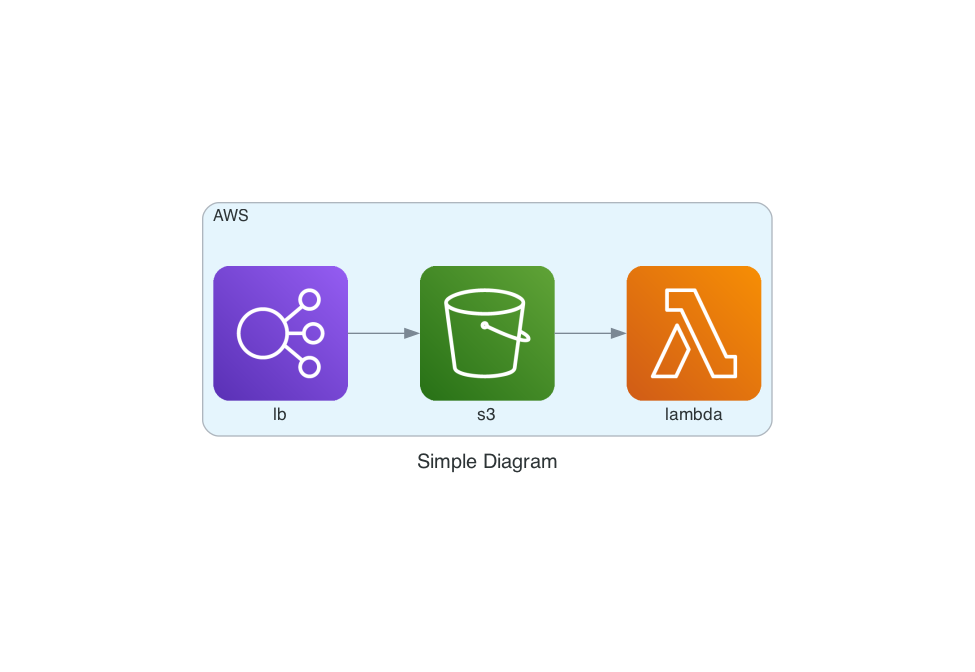

In [8]:
query = "A diagram that shows an s3 bucket connected to a lambda function"
diagram_gen_tool = DiagramCreationTool()
diagram_gen_tool(query)

### Starting the agent

To start the agent we select what LLM to use ( Starcoder https://huggingface.co/bigcode/starcoder for this example) our custom prompt, and additional tools. We also delete the default tools so the agent so just uses our custom tools.


In [9]:
# Start Agent
BASE_MODEL = "bigcode/starcoderbase"

agent = HfAgent(
    f"https://api-inference.huggingface.co/models/{BASE_MODEL}",
    token=HUGGING_FACE_KEY,
    run_prompt_template=sa_prompt,
    additional_tools=[code_gen_tool, well_arch_tool, diagram_gen_tool],
)


default_tools = ['document_qa',
 'image_captioner',
 'image_qa',
 'image_segmenter',
 'transcriber',
 'summarizer',
 'text_classifier',
 'text_qa',
 'text_reader',
 'translator',
 'image_transformer',
 'text_downloader',
 'image_generator',
 'video_generator',
]

# Remove default tools
for tool in default_tools:
    try:
        del agent.toolbox[tool]
    except:
        continue

==Explanation from the agent==
I will use the following


==Code generated by the agent==
architecture_diagram = diagram_creation_tool(query="A diagram that shows an EC2 Cluster connected to a lambda function")


==Result==


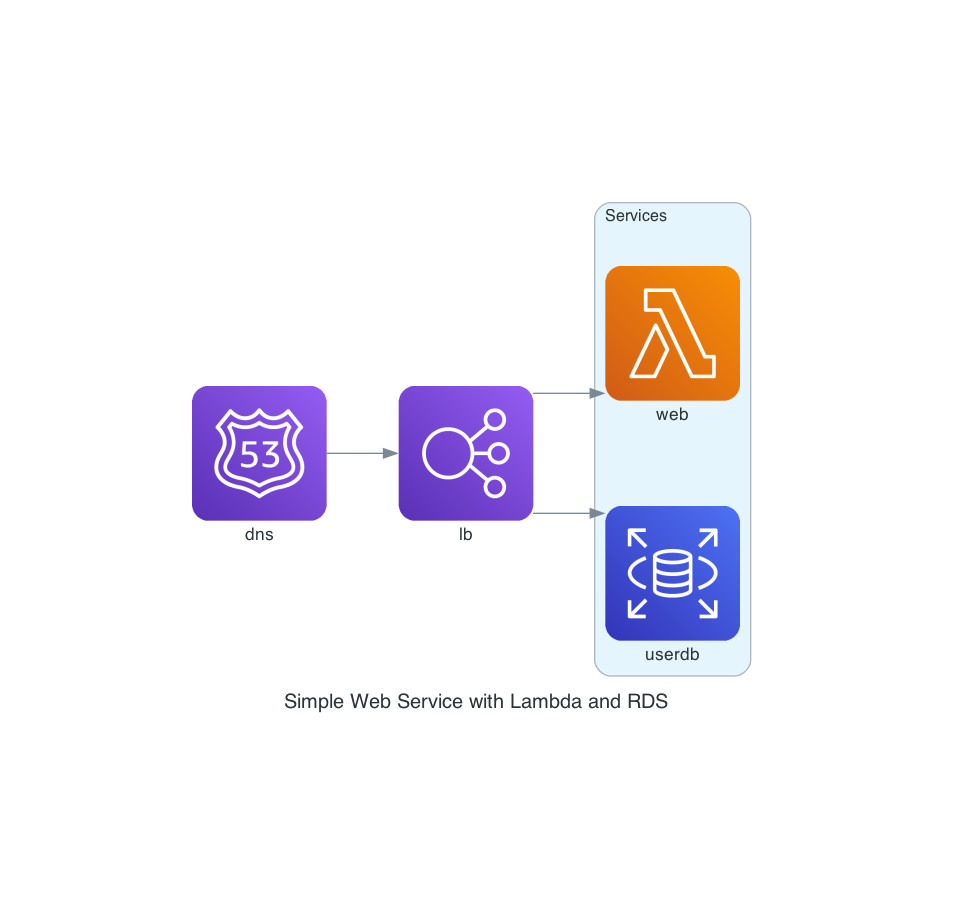

In [10]:
agent.run("A diagram that shows an EC2 Cluster connected to a lambda function")

In [11]:
agent.run("How would I secure my Amazon S3 buckets?")

==Explanation from the agent==
I will use the following


==Code generated by the agent==
response = well_architected_tool(query="How would I secure my Amazon S3 buckets?")
print(f"{response}.")


==Result==
 You can secure your Amazon S3 buckets by implementing the following best practices:

        1. Use IAM roles to restrict access to your Amazon S3 buckets.
        2. Use bucket-level permissions to restrict access to your Amazon S3 buckets.
        3. Use bucket-level encryption to encrypt data stored in your Amazon S3 buckets.
        4. Use bucket-level access control to restrict access to your Amazon S3 buckets.
        5. Use bucket-level versioning to restrict access to your Amazon S3 buckets.
        6. Use bucket-level object locking to restrict access to your Amazon S3 buckets.
        7. Use bucket-level access control to restrict access to your Amazon S3 buckets.
        8. Use bucket-level object locking to restrict access to your Amazon S3 buckets.
        9. Use buck

{'ans': ' You can secure your Amazon S3 buckets by implementing the following best practices:\n\n        1. Use IAM roles to restrict access to your Amazon S3 buckets.\n        2. Use bucket-level permissions to restrict access to your Amazon S3 buckets.\n        3. Use bucket-level encryption to encrypt data stored in your Amazon S3 buckets.\n        4. Use bucket-level access control to restrict access to your Amazon S3 buckets.\n        5. Use bucket-level versioning to restrict access to your Amazon S3 buckets.\n        6. Use bucket-level object locking to restrict access to your Amazon S3 buckets.\n        7. Use bucket-level access control to restrict access to your Amazon S3 buckets.\n        8. Use bucket-level object locking to restrict access to your Amazon S3 buckets.\n        9. Use bucket-level access control to restrict access to your Amazon S3 buckets.\n        10. Use bucket-level access control to restrict access to your Amazon S3 buckets.',
 'docs': 'https://docs.aws

In [12]:
agent.run("Write a function in Python to upload a file to Amazon S3")

==Explanation from the agent==
I will use the following


==Code generated by the agent==
python_code = code_generation_tool(prompt="Write a function in Python to upload a file to Amazon S3")
print(f"{python_code}")


==Result==


import boto3

def upload_file_to_s3(file_name, bucket, object_name=None):
    """Upload a file to an S3 bucket

    :param file_name: File to upload
    :param bucket: Bucket to upload to
    :param object_name: S3 object name. If not specified then file_name is used
    :return: True if file was uploaded, else False
    """

    # If S3 object_name was not specified, use file_name
    if object_name is None:
        object_name = file_name

    # Upload the file
    s3_client = boto3.client('s3')
    try:
        response = s3_client.upload_file(file_name, bucket, object_name)
    except ClientError as e:
        logging.error(e)
        return False
    return True



'\n\nimport boto3\n\ndef upload_file_to_s3(file_name, bucket, object_name=None):\n    """Upload a file to an S3 bucket\n\n    :param file_name: File to upload\n    :param bucket: Bucket to upload to\n    :param object_name: S3 object name. If not specified then file_name is used\n    :return: True if file was uploaded, else False\n    """\n\n    # If S3 object_name was not specified, use file_name\n    if object_name is None:\n        object_name = file_name\n\n    # Upload the file\n    s3_client = boto3.client(\'s3\')\n    try:\n        response = s3_client.upload_file(file_name, bucket, object_name)\n    except ClientError as e:\n        logging.error(e)\n        return False\n    return True\n'